# Spectral clustering


In [70]:
import os
import glob
import napari_shape_odyssey as nso
import vedo
import scipy.sparse.linalg
import numpy as np
import tqdm
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

import napari
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
root = r'C:\Users\johamuel\Documents\BiAPoL\Projects\meshes\objects'
mesh_files = glob.glob(os.path.join(root, '**/*.obj'))

In [59]:
viewer = napari.Viewer()

In [71]:
eigenvalues = []
eigenvectors = []
meshes = []
for file in tqdm.tqdm(mesh_files):
    # load and preprocess meshes
    mesh = vedo.load(file).triangulate().clean().decimate(n=5000)
    bounding_box_volume = np.prod(mesh.bounds()[1] - mesh.bounds()[0])
    mesh.scale(1 / bounding_box_volume)

    mesh_tuple = (mesh.points(), np.asarray(mesh.faces()))
    meshes.append(mesh_tuple)
    viewer.add_surface(mesh_tuple, name = os.path.basename(file))
    _eigenvectors, _eigenvalues = nso.spectral.shape_fingerprint(mesh_tuple, order = 20)

    eigenvalues.append(_eigenvalues)
    eigenvectors.append(_eigenvectors)

100%|██████████| 55/55 [03:12<00:00,  3.50s/it]


In [72]:
# stack eigenvalues into dataframe
eigenvalues_stack = np.stack(eigenvalues)
df = pd.DataFrame(eigenvalues_stack, columns = [f'lambda_{i}' for i in range(eigenvalues_stack.shape[1])])
df['file'] = mesh_files
df.head()

,lambda_0,lambda_1,lambda_2,lambda_3,lambda_4,lambda_5,lambda_6,lambda_7,lambda_8,lambda_9,...,lambda_11,lambda_12,lambda_13,lambda_14,lambda_15,lambda_16,lambda_17,lambda_18,lambda_19,file
0,-1.953646e-14,3.497411,4.534560,5.684497,9.985113,14.893090,22.529184,29.669639,30.541655,37.723114,...,52.551030,58.486390,63.681724,64.850003,71.539644,78.696079,81.764765,95.658377,102.104163,C:\Users\johamuel\Documents\BiAPoL\Projects\me...
1,-2.588207e-15,0.683063,2.141403,4.065282,4.768848,4.828398,7.341017,7.398343,7.880799,10.123669,...,11.785636,13.405222,14.186425,15.805213,16.056310,16.568611,18.689970,19.308144,21.437427,C:\Users\johamuel\Documents\BiAPoL\Projects\me...
2,-3.479855e-14,7.361894,14.320784,29.855033,33.864331,38.218302,51.627914,55.100373,63.052792,71.963617,...,91.888147,95.434760,99.987659,114.406247,123.437142,127.149471,140.136072,142.793974,153.672580,C:\Users\johamuel\Documents\BiAPoL\Projects\me...
3,8.767292e-15,5.616643,7.917237,8.444330,16.360097,19.160159,20.802747,22.530132,30.035678,35.645911,...,40.187326,41.239513,45.143890,48.583533,55.172578,60.318931,60.867925,64.006032,70.048105,C:\Users\johamuel\Documents\BiAPoL\Projects\me...
4,5.911938e-15,4.346719,11.623099,12.111892,14.928216,17.026181,24.693182,35.492465,41.155620,44.683491,...,54.133487,57.104238,65.311068,79.894249,84.290943,85.177407,88.444672,89.997874,101.211198,C:\Users\johamuel\Documents\BiAPoL\Projects\me...


In [93]:
embedder = TSNE(n_components=2)
X_embedded = embedder.fit_transform(df.drop('file', axis = 1))

clusterer = DBSCAN(eps=0.25, min_samples=2)
clusterer.fit(X_embedded)

for idx, layer in enumerate(viewer.layers):
    mesh_tuple = list(layer.data)
    mesh_tuple[-1] *= clusterer.labels_[idx]
    viewer.layers[idx].data = tuple(mesh_tuple)
    viewer.layers[idx].colormap = 'hsv'
    viewer.layers[idx].contrast_limits = [-1, np.max(clusterer.labels_)]


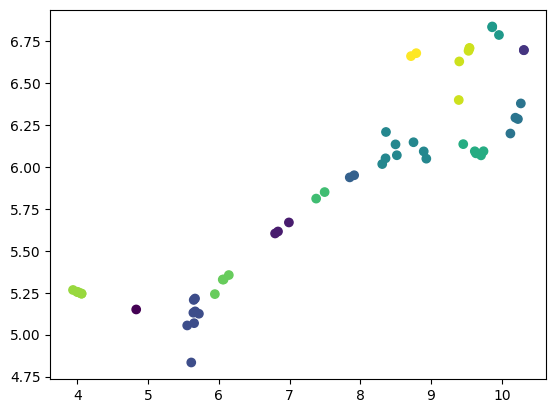

In [94]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = clusterer.labels_)

In [98]:
for idx in np.argwhere(clusterer.labels_==4):
    viewer.add_surface(meshes[idx[0]], name = os.path.basename(mesh_files[idx[0]]))